# Sampling from Truncated Distributions [4] 

For this post we're going to delve a bit deeper still and we will have a close look at the computational efficiency of the samplers. I use the 2D example from [1] again but I will now apply changes to the sampled distribution. 
More specifically, I will change the location of the mode of the (unconstrained) multivariate normal distribution. I will work with the rotated versions of the density as studied in the previous post. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cvxpy as cvx
from os import path
import sys

sys.path.append(path.abspath(path.join(path.abspath('') ,"../../truncsample")))

from truncsample.tmvn import truncmvn

### Mode shift
The next figures show 5 modified versions of the sampled density. From top to bottom, one can see that the mode of the (untruncated) distribution is shifted gradually from (-4,0) to (+4,0). In the analysis below, I will actually compute results for 65 modified versions in this range of distributions.

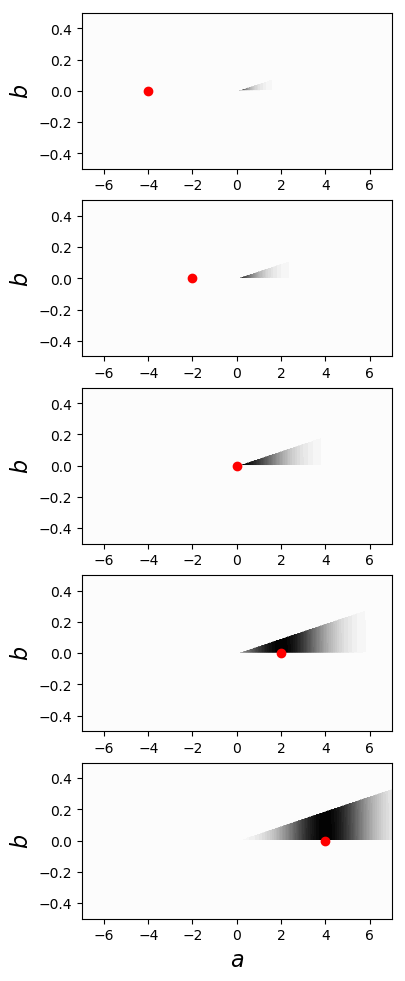

In [2]:
cov     =   True 

N = 5
poslow = -4
posupp = 4
s_ = np.linspace(poslow,posupp,N)

a       =   np.linspace(-7,+7,256);
b       =   np.linspace(-.5,+.5,256);

na      =   len(a)
nb      =   len(b)
N       =   2
sigpar  =   1
cmap    =   plt.cm.get_cmap("gray")
fig     =   plt.figure(figsize=(4,12),dpi=100)

j =0 ;
for s in s_:
    j +=1
    F2       =   np.array([[0,+1],[+0.05,-1.05]])
    g2       =   np.array([1,1])*0
    mu2      =   np.array([+1,+0])*s
    M2       =   np.array([[+1,0],[0,+1]])

    TMVN2   =   truncmvn(mu2, M2, F2, g2, cov)

    index = str(100*len(s_)+10+j)
    fig.add_subplot(index);
    mode    =   TMVN2.getmode()
    
    L       =   np.zeros([nb,na])
    for ia in range(0,na):
        for ib in range(0,nb):
            x   =   np.array([a[ia],b[ib]])
            if np.all (TMVN2.F.dot (x) + TMVN2.g > 0):
                L[ib,ia]   =   np.exp(-( (x[0]-TMVN2.mu[0])**2 +(x[1]-TMVN2.mu[1])**2 )/(2*sigpar*N) - 1/2*np.log(2*np.pi) - 1/2*np.log(sigpar**2) ) 
            else :
                L[ib,ia]   =   0
    
    ax      =   fig.gca()
    
    ax.contourf(a, b,-L/np.max(L),42,cmap='gray')
    plt.plot(mu2[0],mu2[1],'ro')
    if s==s_[-1]:
        ax.set_xlabel('$a$', fontsize=16)
    ax.set_ylabel('$b$', fontsize=16)


We now sample from 65 of these distributions with every sampler and compare the time needed per computed sample. The next figure shows this computational efficiency as a function of the position of the mode along the x-axis. There are a number of interesting observations to make:

* The computational efficiency of the Gibbs and hit-and-run samplers is insensitive to the position of the mode, I need about half a millisecond per sample on my own laptop.

* The computational efficiency of rejection sampler and the HMC sampler increases when the mode is shifted towards the boundary of the feasible region and further away from the feasible region. For the rejection sampler, this is because the acceptance rate goes down quite dramatically. In the case of the HMC sampler this is because of the number of times the ellipsoidal trajectories are reflected on the boundaries of the feasible region increases as the mode is shifted to the left. The computations associated with these reflections contribute quite dramatically to the computational time. The second graph below shows the average number of reflections per sample. One can see that this number gets above 100 bounces per sample on the left side of the graph.

* For most of the considered mode positions, the HMC sampler is significantly slower than the rejection sampler. For example, the time needed per sample when $\mu=[+4,0]$ (left-side of plot below) is a factor 500 higher with the HMC sampler compared to the rejection sampler. This changes when the mode is moved outside of the feasible region. For these cases, the HMC sampler becomes more attractive than the rejection sampler. 

* The computationally most efficient sampler is either the rejection sampler or the hit-and-run sampler.

In [3]:
K=1000

import timeit

N = 65
s_ = np.linspace(poslow,posupp,N)

lapsedtime= np.nan*np.ones((len(s_),4))
bounces = np.nan*np.ones(len(s_))
j =0 ;
for s in s_:
    print(s)
    F2       =   np.array([[0,+1],[+0.05,-1.05]])
    g2       =   np.array([1,1])*0
    mu2      =   np.array([+1,+0])*s
    M2       =   np.array([[+1,0],[0,+1]])

    TMVN2   =   truncmvn(mu2, M2, F2, g2, cov)
    ystart = TMVN2.getmode()+np.array([+1,+0.01])
    
    
    for p in range(4):
        start = timeit.default_timer()
        np.random.seed(42)
        if p==0:
            Y0, bounce = TMVN2.sample(K,y0=ystart,sampler='gibbs')
            Ke = np.shape(Y0)[1]
        elif p==1:
            Y1, bounce= TMVN2.sample(K,y0=ystart,sampler='hitandrun')
            Ke = np.shape(Y1)[1]
        elif p==2:
            Y2, bounce= TMVN2.sample(K,y0=ystart,sampler='hmc')
            Ke = np.shape(Y2)[1]
            bounces[j] = np.mean(bounce)
        elif p==3:
            Y3,bounce = TMVN2.sample(K,y0=ystart,sampler='rejection')
            Ke = np.shape(Y3)[1]
        
        stop = timeit.default_timer()
        if Ke>0:
            lapsedtime[j,p] = (stop - start)/Ke
    
    j +=1
    

-4.0
... rejection sampler - total number of trials has reached 102002000 without reaching target of 1000 successes. I quit!
-3.875
... rejection sampler - total number of trials has reached 102002000 without reaching target of 1000 successes. I quit!
-3.75
... rejection sampler - total number of trials has reached 102002000 without reaching target of 1000 successes. I quit!
-3.625
... rejection sampler - total number of trials has reached 102002000 without reaching target of 1000 successes. I quit!
-3.5
... rejection sampler - total number of trials has reached 102002000 without reaching target of 1000 successes. I quit!
-3.375
... rejection sampler - total number of trials has reached 102002000 without reaching target of 1000 successes. I quit!
-3.25
... rejection sampler - total number of trials has reached 102002000 without reaching target of 1000 successes. I quit!
-3.125
... rejection sampler - total number of trials has reached 102002000 without reaching target of 1000 successes

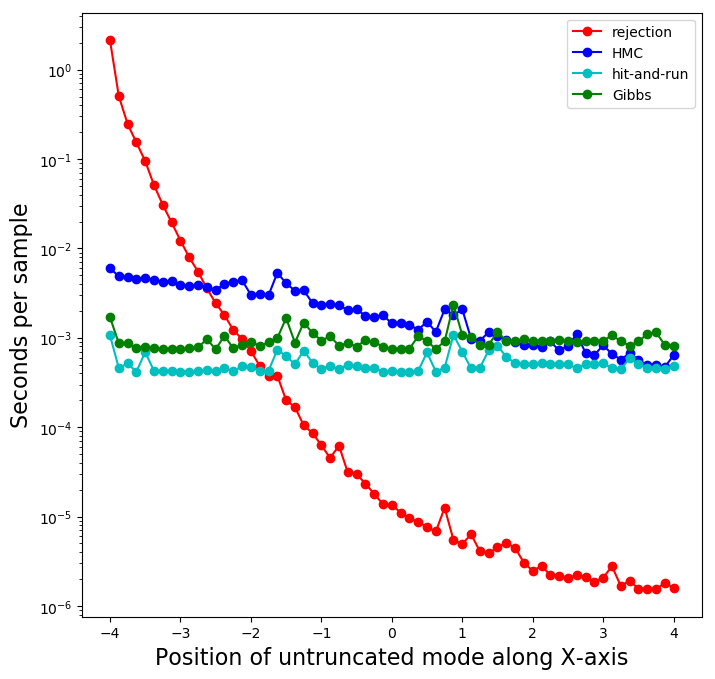

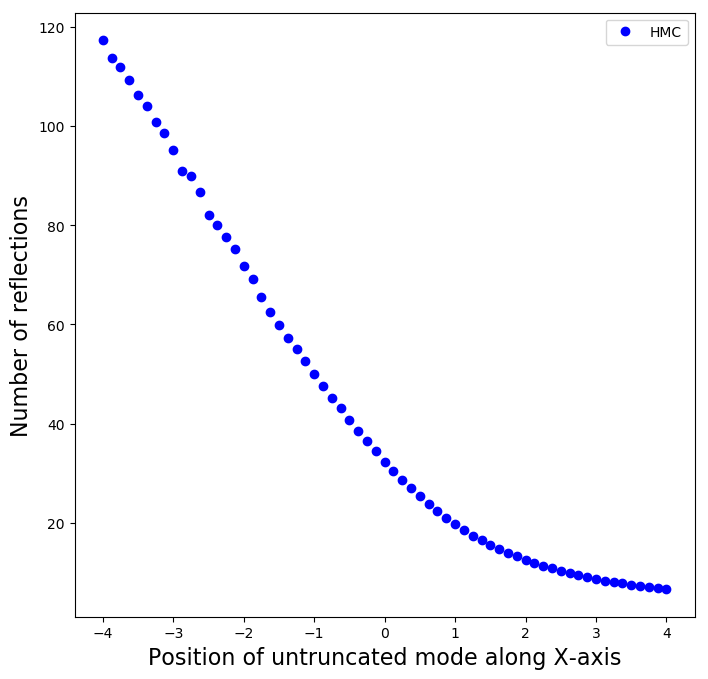

In [4]:
fig     =   plt.figure(figsize=(8,8),dpi=100)
ax = fig.gca()
h0, = plt.plot(s_,lapsedtime[:,3],'ro-',label="rejection")
h1, = plt.plot(s_,lapsedtime[:,2],'bo-',label="HMC")
h2, = plt.plot(s_,lapsedtime[:,1],'co-',label="hit-and-run")
h3, = plt.plot(s_,lapsedtime[:,0],'go-',label="Gibbs")
plt.legend(handles=[h0,h1,h2,h3]);
ax.set_yscale('log');
ax.set_ylabel('Seconds per sample', fontsize=16);
ax.set_xlabel('Position of untruncated mode along X-axis', fontsize=16);
plt.show;

fig     =   plt.figure(figsize=(8,8),dpi=100)
ax = fig.gca()
h4, = plt.plot(s_,bounces,'bo',label="HMC")
plt.legend(handles=[h4]);
ax.set_ylabel('Number of reflections', fontsize=16);
ax.set_xlabel('Position of untruncated mode along X-axis', fontsize=16);
plt.show;

### Take home message

* The rejection sampler, although exhibiting a low acceptance rate, is actually quite efficient when considering computational requirement per sample
* Despite its sophistication, the HMC does not always perform well. The computational cost associated with the bounces against the boundaries of the feasible region can be quite high to the point that other samplers are more efficient
* Even more surprising is that, on computational grounds, HMC is never the best sampler available
* I deliberately ignored to account for autocorrelation in this post. More on that next time.

### References

[1] Pakman, A., & Paninski, L. (2014). Exact Hamiltonian Monte Carlo for truncated multivariate Gaussians. Journal of Computational and Graphical Statistics, 23(2), 518-542.